In [1]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from tensorflow import keras
import random as rand
import cv2
import pandas as pd
np.set_printoptions(suppress=True)

x_digit = idx2numpy.convert_from_file('data/train-images-idx3-ubyte')
y_digit = idx2numpy.convert_from_file('data/train-labels-idx1-ubyte')

print(x_digit.shape, y_digit.shape)
BATCH_SIZE = 4
TRAIN_SIZE = 32
TEST_SIZE = 5000
EPOCHS = 1200
OUTER_IMG_SZ = 150

(60000, 28, 28) (60000,)


In [2]:
### Generate train and test data using mnist set with NUM_SIZE digits
GRID_SIDE = 9

image_dict = [[] for i in range(10)]
for digit,image in zip(y_digit, x_digit):
    image_dict[digit].append(image)

In [3]:
def normalize(arr):
    mn = np.amin(arr) 
    mx = np.amax(arr) 
    return (arr - mn)/(mx - mn)

In [4]:
def arr_stats(arr):
    mn = np.amin(arr) 
    mx = np.amax(arr) 
    rng = np.ptp(arr) 
    varience = np.var(arr) 
    sd = np.std(arr) 
    print("Measures of Dispersion") 
    print("Minimum =", mn) 
    print("Maximum =", mx) 
    print("Range =", rng) 
    print("Varience =", varience) 
    print("Standard Deviation =", sd) 
    print(arr)
    plt.imshow(arr)

In [5]:
class SudokuPuzzleGenerator(keras.utils.Sequence):
    
    def __init__(self, length_of_set, batch_size=BATCH_SIZE):
        self.batch_size = batch_size
        self.length_of_set = length_of_set
        self.epoch_count = 0.0
    
    def __len__(self):
        'Denotes the number of batches per epoch 10k/128'
        ret = self.length_of_set // self.batch_size
        #print("Returning length as " + str(ret))
        return ret

    def __getitem__(self, index):
        'Generate one batch of data'
        #print("Getting item for index " + str(index))
        # Generate indexes of the batch
        #print("using batch_size " + str(self.batch_size))
        x, y = self.gen_test_data(self.batch_size)
        #print("Shapes of returned ", x.shape, y.shape)
        return x, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.epoch_count += 1.0
        #print("An epoch ended >>>>>>> xxxxxxx >>>>>> qqq >>>>")
    
    
    def warp_image(self, img, offsets, puzzle_size):
        top = offsets[0]
        left = offsets[1]
        bottom = offsets[2]
        right = offsets[3]
        
        top_left = [left, top]
        bottom_left = [left, bottom]
        top_right = [right, top]
        bottom_right = [right, bottom]
        
        #print("\nInput offsets: " + str(offsets))
              
        initial_pts = np.float32([top_left, bottom_left, top_right, bottom_right])
        
        #print("\nInput points: " + str(initial_pts))

    
        #translate each offset by upto 30% of the puzzle_size taking care not to go out of OUTER_IMG_SZ
        
        puzzle_size_percent = int(puzzle_size * 0.1)
        
        max_trans_top = min(top, puzzle_size_percent)
        
        max_trans_left = min(left, puzzle_size_percent)
        
        max_trans_bottom = min(OUTER_IMG_SZ - bottom, puzzle_size_percent)
        
        max_trans_right = min(OUTER_IMG_SZ - right, puzzle_size_percent)
        
        top_left = [left + rand.randint(-max_trans_left, max_trans_left), top + rand.randint(-max_trans_top, max_trans_top)]
        bottom_left = [left + rand.randint(-max_trans_left, max_trans_left), bottom + rand.randint(-max_trans_bottom, max_trans_bottom)]
        top_right = [right + rand.randint(-max_trans_right, max_trans_right), top + rand.randint(-max_trans_top, max_trans_top)]
        bottom_right = [right + rand.randint(-max_trans_right, max_trans_right), bottom + rand.randint(-max_trans_bottom, max_trans_bottom)]
        
        dest_pts = np.float32([top_left, bottom_left, top_right, bottom_right])
        
        warp_matrix = cv2.getPerspectiveTransform(initial_pts, dest_pts)
        warped_img = cv2.warpPerspective(img, warp_matrix, (OUTER_IMG_SZ, OUTER_IMG_SZ), borderMode = cv2.BORDER_REFLECT_101 )
        
        warped_offsets = [top, left, bottom,right]
                
        #print("\nwarped offsets: " + str(warped_offsets))
        #print("\nwarped points: " + str(dest_pts))
        #print("\nwarped points2: " , dest_pts.reshape((8)).shape)

        
        return warped_img, dest_pts.reshape(8)

    def process_img(self, img):
        #arr_stats(img)
        return img
    
    def gen_test_data(self, num_data):
        x_data, y_data = np.zeros((num_data, OUTER_IMG_SZ , OUTER_IMG_SZ)), np.zeros((num_data, 8))
        #x_data, y_data = 100 * np.random.randn(num_data, OUTER_IMG_SZ , OUTER_IMG_SZ), np.zeros((num_data, 8))
        for i in range(num_data):
            #pick a random size so that the grid is at least 50% of the overall image
            border_sz = rand.randint(1,2)
            digit_sz = rand.randint(OUTER_IMG_SZ//(2 * GRID_SIDE), OUTER_IMG_SZ//GRID_SIDE) - 2 * border_sz
            border_digit_sz  = digit_sz + 2 * border_sz
            grid_size = GRID_SIDE * (border_digit_sz)
            #pick random offsets so image doesn't go off screen
            x_offset = rand.randint(0, OUTER_IMG_SZ - grid_size)
            y_offset = rand.randint(0, OUTER_IMG_SZ - grid_size)
            offsets = [y_offset, x_offset, y_offset + grid_size, x_offset + grid_size]
            x_data[i] = np.random.randint(0, 255, size = ((OUTER_IMG_SZ , OUTER_IMG_SZ)))
            clr = list(np.random.choice(range(256), size=3))
            for k in range(GRID_SIDE**2):
                #rand_digit = rand.randint(0,9)
                #rand_img = rand.choice(image_dict[rand_digit])
                rand_img = np.random.randint(0,255, size = (digit_sz, digit_sz))
                #rand_img = cv2.resize(rand_img, (digit_sz, digit_sz))
                #if rand_digit == 0 : rand_img = np.zeros((digit_sz, digit_sz))
                rand_img = cv2.copyMakeBorder(rand_img, border_sz,border_sz,border_sz,border_sz, cv2.BORDER_CONSTANT, value = [int(clr[0]),int(clr[1]),int(clr[2])])
                r = k//GRID_SIDE
                c = k % GRID_SIDE
                x_data[i, y_offset + r*border_digit_sz:y_offset + (r+1)*border_digit_sz, x_offset + border_digit_sz*c:x_offset + border_digit_sz*(c+1)] = rand_img
                
            x_data[i], y_data[i] = self.warp_image(x_data[i], offsets, grid_size)
            x_data[i] = self.process_img(x_data[i])
        x_data = normalize(x_data)
        return x_data, y_data
    

In [6]:
def visualize(img, coords):
   
    circle1 = plt.Circle((coords[0],coords[1]) , 5, color='r')
    circle2 = plt.Circle((coords[2],coords[3]) , 5, color='r')
    circle3 = plt.Circle((coords[4],coords[5]) , 5, color='r')
    circle4 = plt.Circle((coords[6],coords[7]) , 5, color='r')
    
    
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    plt.gca().add_patch(circle3)
    plt.gca().add_patch(circle4)
    
        
    plt.imshow(img)
    plt.show()

(150, 150)


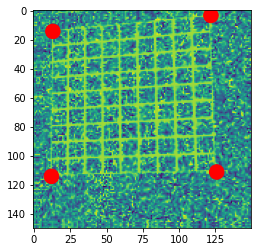

Measures of Dispersion
Minimum = 0.04396832003518251
Maximum = 0.954305194524722
Range = 0.9103368744895395
Varience = 0.03015722585359684
Standard Deviation = 0.17365835958454992
[[0.59485142 0.5314856  0.56383309 ... 0.63988778 0.60473374 0.5944509 ]
 [0.65242056 0.50337162 0.48808983 ... 0.58834231 0.58794069 0.56202193]
 [0.65694992 0.52120853 0.46569705 ... 0.49403645 0.5389998  0.56352092]
 ...
 [0.60907363 0.59979239 0.54597685 ... 0.42620299 0.45415733 0.55039816]
 [0.64115313 0.52722626 0.39964819 ... 0.45136551 0.43777928 0.45787621]
 [0.79007508 0.55659338 0.35005713 ... 0.62103411 0.56017937 0.46158196]]


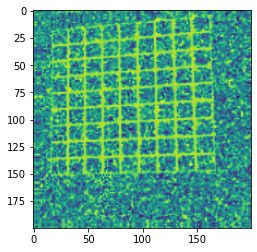

In [7]:
gen = SudokuPuzzleGenerator(1)
x,y = gen.gen_test_data(1)
print(x[0].shape)
visualize(x[0], y[0])
plt.show()
arr_stats(cv2.resize(x[0],(200,200)))
#print(x)

In [8]:
act = 'relu'
pad = 'same'
strd = 1
filter_size_mul = 7
krnl_sz = 7
input_layer = tf.keras.Input(shape = (OUTER_IMG_SZ, OUTER_IMG_SZ,1))
'''
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*2, kernel_size=krnl_sz, activation = act, padding = pad, strides=2)(input_layer)
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*2, kernel_size=krnl_sz, activation = act, padding = pad, strides=strd)(_) 
#_ = tf.keras.layers.MaxPool2D()(_)
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*4, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*4, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.MaxPool2D()(_)
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*8, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*8, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 


_ = tf.keras.layers.AveragePooling2D()(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*5, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*5, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.AveragePooling2D()(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*6, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*6, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 

_ = tf.keras.layers.MaxPool2D()(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*16, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*16, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_)
_ = tf.keras.layers.MaxPool2D()(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*32, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*32, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_)
_ = tf.keras.layers.MaxPool2D()(_)
'''

common_layer = tf.keras.layers.Flatten()(input_layer)

'''
top_y_output_layer = tf.keras.layers.Dense(1, name="top_y")(common_layer)
left_x_output_layer = tf.keras.layers.Dense(1, name="left_x")(common_layer)
bottom_y_output_layer = tf.keras.layers.Dense(1, name="bottom_y")(common_layer)
right_x_output_layer = tf.keras.layers.Dense(1, name="right_x")(common_layer)

output_layers = {'1': top_y_output_layer, '2':left_x_output_layer, '3':bottom_y_output_layer, '4':right_x_output_layer}
loss_fns = {'1': tf.keras.losses.MeanSquaredError(), '2':tf.keras.losses.MeanSquaredError(),'3':tf.keras.losses.MeanSquaredError(), '4': tf.keras.losses.MeanSquaredError()}
'''
common_layer = tf.keras.layers.Dense(15000, activation = act)(common_layer)
common_layer = tf.keras.layers.Dense(10000, activation = act)(common_layer)
common_layer = tf.keras.layers.Dense(8000, activation = act)(common_layer)
common_layer = tf.keras.layers.Dense(4000, activation = act)(common_layer)
common_layer = tf.keras.layers.Dense(1500, activation = act)(common_layer)
common_layer = tf.keras.layers.Dense(800, activation = act)(common_layer)
common_layer = tf.keras.layers.Dense(500, activation = act)(common_layer)
common_layer = tf.keras.layers.Dense(100, activation = act)(common_layer)
output_layers = tf.keras.layers.Dense(8, name="edges")(common_layer)
loss_fns = tf.keras.losses.MeanSquaredError()

model = tf.keras.Model(inputs=input_layer, outputs = output_layers, name="digit_recognizer")
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss = loss_fns,
             metrics = ['accuracy'] )
model.summary()

#model = keras.models.load_model('models/grid_detector_with_noise')


Model: "digit_recognizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 22500)             0         
_________________________________________________________________
dense (Dense)                (None, 15000)             337515000 
_________________________________________________________________
dense_1 (Dense)              (None, 10000)             150010000 
_________________________________________________________________
dense_2 (Dense)              (None, 8000)              80008000  
_________________________________________________________________
dense_3 (Dense)              (None, 4000)              32004000  
_________________________________________________________________
dense_4 (Dense)              (None, 1500)         

In [9]:
training_gen = SudokuPuzzleGenerator(TRAIN_SIZE)
validation_gen = SudokuPuzzleGenerator(TEST_SIZE)

In [10]:
model.fit(x = training_gen, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/1200
8/8 [==============================] - 15s 636ms/step - loss: 726650.1044 - accuracy: 0.3777
Epoch 2/1200
8/8 [==============================] - 5s 618ms/step - loss: 2629.2658 - accuracy: 0.1744
Epoch 3/1200
8/8 [==============================] - 5s 610ms/step - loss: 896.9422 - accuracy: 0.1096
Epoch 4/1200
8/8 [==============================] - 5s 609ms/step - loss: 930.5601 - accuracy: 0.3749
Epoch 5/1200
8/8 [==============================] - 5s 609ms/step - loss: 1135.2403 - accuracy: 0.1727
Epoch 6/1200
8/8 [==============================] - 5s 610ms/step - loss: 1076.4386 - accuracy: 0.3927
Epoch 7/1200
8/8 [==============================] - 5s 606ms/step - loss: 526.3989 - accuracy: 0.2560
Epoch 8/1200
8/8 [==============================] - 5s 608ms/step - loss: 697.9495 - accuracy: 0.2843
Epoch 9/1200
8/8 [==============================] - 5s 611ms/step - loss: 994.7319 - accuracy: 0.3524
Epoch 10/1200
8/8 [==============================] - 5s 678ms/step - loss: 

8/8 [==============================] - 5s 631ms/step - loss: 381.0872 - accuracy: 0.2579
Epoch 81/1200
8/8 [==============================] - 5s 638ms/step - loss: 447.8888 - accuracy: 0.1733
Epoch 82/1200
8/8 [==============================] - 5s 634ms/step - loss: 409.4256 - accuracy: 0.3607
Epoch 83/1200
8/8 [==============================] - 5s 632ms/step - loss: 514.7178 - accuracy: 0.1618
Epoch 84/1200
8/8 [==============================] - 5s 637ms/step - loss: 499.7099 - accuracy: 0.1692
Epoch 85/1200
8/8 [==============================] - 5s 629ms/step - loss: 469.3731 - accuracy: 0.4947
Epoch 86/1200
8/8 [==============================] - 5s 634ms/step - loss: 455.3921 - accuracy: 0.4105
Epoch 87/1200
8/8 [==============================] - 5s 661ms/step - loss: 586.8563 - accuracy: 0.2278
Epoch 88/1200
8/8 [==============================] - 5s 636ms/step - loss: 757.5031 - accuracy: 0.1912
Epoch 89/1200
8/8 [==============================] - 5s 653ms/step - loss: 1104.0112 - 

KeyboardInterrupt: 

In [12]:
model.evaluate(x=validation_gen, y=None, verbose=1)

9/9 [==============================] - 25s 3s/step - loss: 83.8515 - accuracy: 0.3618


[83.85154724121094, 0.3617621660232544]

In [11]:
model.save('models/grid_detector_with_only_borders_shrunk_densenets')

/opt/homebrew/Caskroom/miniforge/base/envs/p38TF/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/opt/homebrew/Caskroom/miniforge/base/envs/p38TF/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: models/grid_detector_with_only_borders_shrunk_densenets/assets


(1, 150, 150) (1, 8)


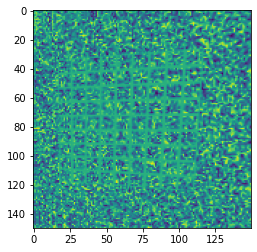

[[ 17.  34.  18. 118. 118.  26. 111. 125.]]
[[  7.701939   18.251513    7.5852885 128.65363   117.860306   17.373247
  118.34354   129.44153  ]]


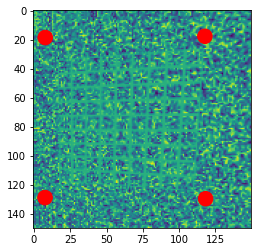

In [21]:
x,y = training_gen.gen_test_data(1)
#_, x = cv2.threshold(x, 127, 255, cv2.THRESH_BINARY)
print(x.shape, y.shape)
plt.imshow(x[0])
plt.show()
print(y)
pred  = model.predict(x)
print(pred)
visualize(x[0], pred[0])
matplotlib.image.imsave('saved.png', x[0])

In [ ]:
dgen = tf.keras.preprocessing.image.ImageDataGenerator()
tst_img = dgen.apply_transform(x.reshape(512,512,1) , {'shear':5, 'theta' : -25})
plt.imshow(tst_img.reshape(512,512))
model.predict(tst_img.reshape(1,512,512))

In [1]:
visualize(tst_img, model.predict(tst_img.reshape(1,512,512))[0])

NameError: name 'visualize' is not defined

(1000, 833)


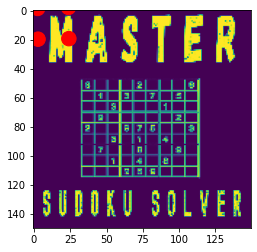

[ 2.48887   -1.8350207  2.7480829 19.373053  23.751553  -2.5200777
 24.012527  19.009102 ]


0

In [29]:
def from_img():
    img = cv2.imread('1.png', cv2.IMREAD_GRAYSCALE)
    print(img.shape)
    img = cv2.resize(img, (150,150))
    img = normalize(img)
    visualize(img, model.predict(img.reshape(1,150,150))[0])
    print(model.predict(img.reshape(1,150,150))[0])
    #arr_stats(cv2.resize(img, (200,200)))
    return 0
from_img()